## FESTIM model

In [2]:
import festim as F
import fenics as f
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

################### PARAMETERS ###################
# Exposure conditions
T_exposure = 600
t_exposure = 48 * 3600
Gamma_atom = 5.8e18

t_des = 43 * 3600

final_time = t_exposure + t_des
# Sample
L = 0.8e-3  # half thickness, m

# W properties
rho_W = 6.3e28  # W atomic concentration, m^-3
n_IS = 6 * rho_W  # concentration of interstitial sites, m^-3
n_surf = 6.9 * rho_W ** (2 / 3)  # concentration of adsorption sites, m^-2

nu0 = 1e13  # attempt frequency, s^-1
SP = 0.19
D0 = 1.9e-7 / np.sqrt(2)  # diffusivity pre-factor, m^2 s^-1
E_diff = 0.2  # diffusion activation energy, eV
lambda_IS = 110e-12  # distance between 2 IS sites, m
sigma_exc = 1.7e-21  # Cross-section for the direct abstraction, m^2
lambda_des = 1 / np.sqrt(n_surf)

# Transitions
E_bs = E_diff  # energy barrier from bulk to surface, eV
E_sb = 1.545
E_des = 0.87

################### MODEL ###################


def k_sb(T, surf_conc, t):
    return nu0 * f.exp(-E_sb / F.k_B / T)


def k_bs(T, surf_conc, t):
    return nu0 * f.exp(-E_bs / F.k_B / T)


def J_vs(T, surf_conc, t):
    G_atom = Gamma_atom * f.conditional(t <= t_exposure, 1, 0)

    phi_atom = SP * G_atom * (1 - surf_conc / n_surf)

    phi_exc = G_atom * sigma_exc * surf_conc

    phi_des = 2 * nu0 * (lambda_des * surf_conc) ** 2 * f.exp(-2 * E_des / F.k_B / T)
    return phi_atom - phi_exc - phi_des


W_model = F.Simulation(log_level=40)

# Mesh
vertices = np.concatenate(
    [
        np.linspace(0, 5e-8, num=100),
        np.linspace(5e-8, 5e-6, num=200),
        np.linspace(5e-6, L, num=250),
    ]
)

W_model.mesh = F.MeshFromVertices(np.sort(vertices))

# Materials
tungsten = F.Material(id=1, D_0=D0, E_D=E_diff)
W_model.materials = tungsten

distr = 1 / (1 + sp.exp((F.x - 2.2e-6) / 1.54e-7))

traps = F.Traps(
    [
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=0.85,
            density=1e-4 * rho_W,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=1.00,
            density=1e-4 * rho_W,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=1.65,
            density=0.19e-2 * rho_W * distr,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=1.85,
            density=0.16e-2 * rho_W * distr,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=2.06,
            density=0.02e-2 * rho_W * distr,
            materials=tungsten,
        ),
    ]
)
W_model.traps = traps

W_model.T = T_exposure

my_BC = F.SurfaceKinetics(
    k_sb=k_sb,
    k_bs=k_bs,
    lambda_IS=lambda_IS,
    n_surf=n_surf,
    n_IS=n_IS,
    J_vs=J_vs,
    surfaces=[1, 2],
    initial_condition=0,
    t=F.t,
)

W_model.boundary_conditions = [my_BC]

W_model.dt = F.Stepsize(
    initial_value=1e-5,
    stepsize_change_ratio=1.25,
    max_stepsize=1000,
    dt_min=1e-6,
)

W_model.settings = F.Settings(
    absolute_tolerance=1e8,
    relative_tolerance=1e-12,
    final_time=final_time,
    traps_element_type="DG",
)

# Exports
export_times = [
    2.5 * 3600,
    6 * 3600,
    24.5 * 3600,
    31.5 * 3600,
    48 * 3600,
    68 * 3600,
    91 * 3600,
]

derived_quantities = F.DerivedQuantities(
    [
        F.TotalVolume(field="retention", volume=1),
        F.AdsorbedHydrogen(surface=1),
    ]
)

TXT = F.TXTExport(field="retention", filename="./FESTIM_sim.txt", times=export_times)

W_model.exports = [derived_quantities] + [TXT]

W_model.initialise()
W_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(
/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        3.3e+05 s    Elapsed time so far: 32.3 s


## D content

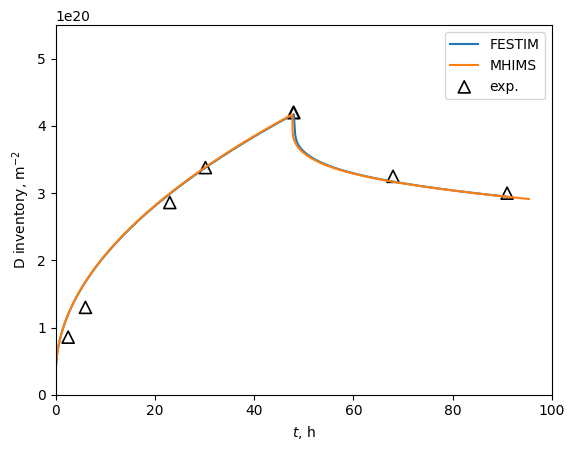

In [3]:
retention = np.array(derived_quantities[0].data) + np.array(derived_quantities[1].data)
t = np.array(derived_quantities.t)

plt.plot(t / 3600, retention, label="FESTIM")

MHIMS_ret = np.loadtxt("./reference_data/MHIMS_ret.csv", delimiter=",", skiprows=1)
plt.plot(MHIMS_ret[:, 0], MHIMS_ret[:, 1], label="MHIMS")

exp_ret = np.loadtxt("./reference_data/exp_ret.csv", delimiter=",", skiprows=1)

plt.scatter(
    exp_ret[:, 0],
    exp_ret[:, 1],
    marker="^",
    s=75,
    ec="black",
    fc="none",
    linewidths=1.2,
    label="exp.",
    zorder=0,
)

plt.xlabel(r"$t$, h")
plt.ylabel(r"D inventory, m$^{-2}$")
plt.legend()
plt.ylim(0, 55e19)
plt.xlim(0, 100)
plt.show()

## D depth distribution

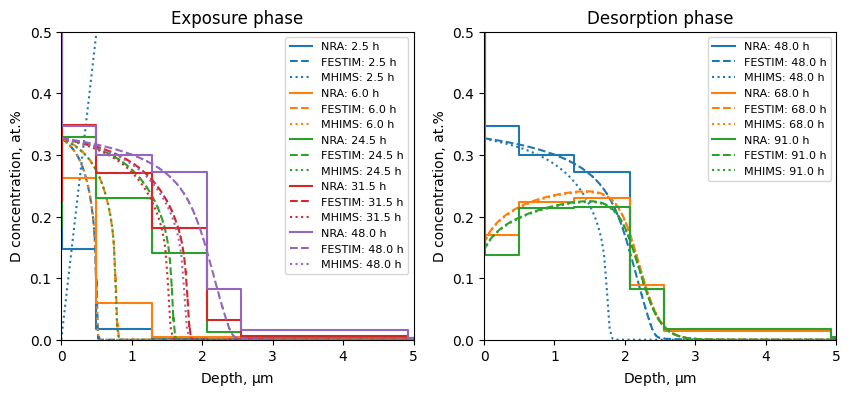

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

FESTIM_profiles = np.genfromtxt("./FESTIM_sim.txt", names=True, delimiter=",")
MHIMS_profiles = np.loadtxt(
    "./reference_data/MHIMS_profiles.csv", delimiter=",", skiprows=1
)
NRA_exp = np.loadtxt("./reference_data/exp_NRA.csv", delimiter=",", skiprows=1)
NRA_sto = np.loadtxt("./reference_data/sto_NRA.csv", delimiter=",", skiprows=1)

for i, t in enumerate(export_times):
    x = FESTIM_profiles["x"]
    y = FESTIM_profiles[f"t{t:.2e}s".replace(".", "").replace("+", "")]
    # order y by x
    x, y = zip(*sorted(zip(x, y)))

    if i < 4:
        (l1,) = ax[0].plot(NRA_exp[:, 0], NRA_exp[:, i + 1], label=f"NRA: {t/3600} h")
        ax[0].plot(
            np.array(x) / 1e-6,
            np.array(y) / rho_W * 100,
            color=l1.get_color(),
            ls="dashed",
            label=f"FESTIM: {t/3600} h",
        )
        ax[0].plot(
            MHIMS_profiles[:, 0],
            MHIMS_profiles[:, i + 1],
            ls="dotted",
            color=l1.get_color(),
            label=f"MHIMS: {t/3600} h",
        )

    elif i == 4:
        (l1,) = ax[0].plot(NRA_exp[:, 0], NRA_exp[:, i + 1], label=f"NRA: {t/3600} h")
        (l2,) = ax[1].plot(NRA_exp[:, 0], NRA_exp[:, i + 1], label=f"NRA: {t/3600} h")

        ax[0].plot(
            np.array(x) / 1e-6,
            np.array(y) / rho_W * 100,
            color=l1.get_color(),
            ls="dashed",
            label=f"FESTIM: {t/3600} h",
        )
        ax[1].plot(
            np.array(x) / 1e-6,
            np.array(y) / rho_W * 100,
            color=l2.get_color(),
            ls="dashed",
            label=f"FESTIM: {t/3600} h",
        )
        ax[0].plot(
            MHIMS_profiles[:, 0],
            MHIMS_profiles[:, i + 1],
            ls="dotted",
            color=l1.get_color(),
            label=f"MHIMS: {t/3600} h",
        )
        ax[1].plot(
            MHIMS_profiles[:, 0],
            MHIMS_profiles[:, i + 1],
            ls="dotted",
            color=l2.get_color(),
            label=f"MHIMS: {t/3600} h",
        )
    else:
        (l1,) = ax[1].plot(NRA_sto[:, 0], NRA_sto[:, i - 4], label=f"NRA: {t/3600} h")
        ax[1].plot(
            np.array(x) / 1e-6,
            np.array(y) / rho_W * 100,
            ls="dashed",
            color=l1.get_color(),
            label=f"FESTIM: {t/3600} h",
        )
        ax[1].plot(
            MHIMS_profiles[:, 0],
            MHIMS_profiles[:, i + 1],
            ls="dotted",
            color=l1.get_color(),
            label=f"MHIMS: {t/3600} h",
        )

ax[0].set_title("Exposure phase")
ax[1].set_title("Desorption phase")
for axis in ax:
    axis.set_xlim(0, 5)
    axis.set_ylim(0, 0.5)
    axis.set_ylabel("D concentration, at.%")
    axis.set_xlabel(r"Depth, $\mathrm{\mu}$m")
    axis.legend(fontsize=8)

plt.show()